# Deep learning MNIST

Experiments using deep learning on the MNIST data set.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import pickle, gzip, numpy

# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
#train_set, valid_set, test_set = pickle.load(f)
train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
f.close()

In [4]:
from sklearn.preprocessing import OneHotEncoder

def preprocess(data):
    X, y = data
    Y = OneHotEncoder().fit_transform(y.reshape(-1,1)).todense()
    X, Y, y = (_.astype(np.float32) for _ in (X, Y, y))
    return X, Y, y

In [5]:
Xtrain, Ytrain, ytrain = preprocess(train_set)
Xtest, Ytest, ytest = preprocess(test_set)

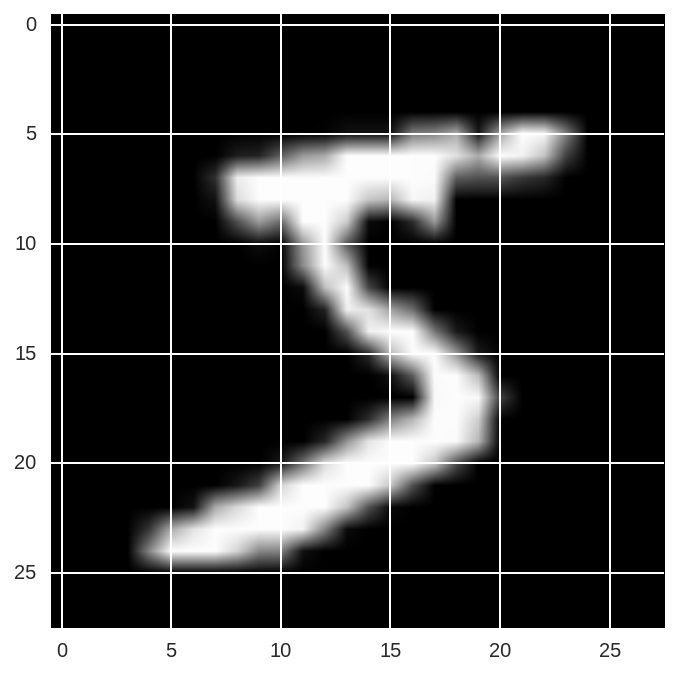

In [6]:
plt.imshow(Xtrain[0].reshape((28,28)), cmap=plt.cm.gray);

In [7]:
Ytrain[0]

matrix([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]], dtype=float32)

# Logistic regression

Probability distribution over $k$ classes modeled as
$p = \sigma (W^T x)$,
where $x$ is a $d$-dimensional feature vector, $W$ is a $d \times k$ matrix, and $\sigma$ is the softmax function.

In [8]:
import theano.tensor as T
from theano import function, shared
from theano.tensor.nnet import softmax
from numpy.random import randn

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled)


In [9]:
d = 784
k = 10

In [10]:
def sgd(cost, params, lr=0.05):
    grads = T.grad(cost, wrt=params)
    return [(p, p - lr*gp) for p, gp in zip(params, grads)]

In [11]:
X = T.matrix('X')
Y = T.matrix('Y')
W = shared(randn(d, k), 'W')
b = shared(randn(k), 'b')

P = softmax(T.dot(X, W) + b)
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1))

train = function([X, Y], cost, updates=sgd(cost, [W, b]))
predict = function([X], pred)
predict_proba = function([X], P)

In [12]:
%%time
for i in range(101):
    cost = train(Xtrain, Ytrain).item()
    if i % 10 == 0:
        accuracy = (ytrain == predict(Xtrain)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, cost, accuracy))

epoch=0 cost=14.5167 accuracy=0.0936
epoch=10 cost=11.7771 accuracy=0.1018
epoch=20 cost=10.3228 accuracy=0.1170
epoch=30 cost=9.3664 accuracy=0.1324
epoch=40 cost=8.6246 accuracy=0.1472
epoch=50 cost=7.9935 accuracy=0.1629
epoch=60 cost=7.4340 accuracy=0.1808
epoch=70 cost=6.9321 accuracy=0.2021
epoch=80 cost=6.4819 accuracy=0.2231
epoch=90 cost=6.0795 accuracy=0.2451
epoch=100 cost=5.7214 accuracy=0.2662
CPU times: user 56.9 s, sys: 8.94 s, total: 1min 5s
Wall time: 1min 5s


In [13]:
(ytest == predict(Xtest)).mean()

0.27760000000000001

# Single hidden layer

In [14]:
from theano.tensor.nnet import relu

In [15]:
k0 = d  # input units
k1 = 25 # units in hidden layer
k2 = k  # output units

In [16]:
X = T.matrix('X')
Y = T.matrix('Y')

W01 = shared(randn(k0, k1), 'W01')
b01 = shared(randn(k1), 'b01')
W12 = shared(randn(k1, k2), 'W12')
b12 = shared(randn(k2), 'b12')

A0 = X
A1 = relu(T.dot(A0, W01) + b01) # rectifier activation function
A2 = softmax(T.dot(A1, W12) + b12)

P = A2
pred = T.argmax(P, axis=1)
cost = -T.mean(T.sum(Y*T.log(P), axis=1))

train = function([X, Y], cost, updates=sgd(cost, [W01, b01, W12, b12]))
predict = function([X], pred)
predict_proba = function([X], P)

In [17]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain).item()
    if i % 10 == 0:
        accuracy = (ytrain == predict(Xtrain)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c, accuracy))

epoch=0 cost=50.5697 accuracy=0.0606
epoch=10 cost=20.7997 accuracy=0.1564
epoch=20 cost=12.4889 accuracy=0.2562
epoch=30 cost=8.8298 accuracy=0.3299
epoch=40 cost=6.9095 accuracy=0.3775
epoch=50 cost=5.7222 accuracy=0.4081
epoch=60 cost=4.9111 accuracy=0.4295
epoch=70 cost=4.3198 accuracy=0.4483
epoch=80 cost=3.8724 accuracy=0.4605
epoch=90 cost=3.5228 accuracy=0.4705
epoch=100 cost=3.2440 accuracy=0.4785
CPU times: user 1min 42s, sys: 1min 6s, total: 2min 48s
Wall time: 51.7 s


# RMSprop

Method of adaptive learning rate. Scale the gradient by a moving average of the magnitude of gradients in previous updates. Greatly speeds up convergence when exploring flatter regions, increases stability in steep regions. 

In [18]:
def rmsprop(cost, params, lr=0.03, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = shared(p.get_value() * 0.) # trick to get 0 of correct type
        acc_new = rho*acc + (1-rho)*g**2
        scale = T.sqrt(acc_new + epsilon)
        g /= scale
        updates.append((acc, acc_new))
        updates.append((p, p - lr*g))
    return updates

In [19]:
train = function([X, Y], cost, updates=rmsprop(cost, [W01, b01, W12, b12]))

In [20]:
# reinitialize weights
W01.set_value(randn(k0, k1))
b01.set_value(randn(k1))
W12.set_value(randn(k1, k2))
b12.set_value(randn(k2))

In [21]:
%%time
for i in range(101):
    c = train(Xtrain, Ytrain).item()
    if i % 10 == 0:
        accuracy = (ytrain == predict(Xtrain)).mean()
        print("epoch={} cost={:.4f} accuracy={:.4f}".format(i, c, accuracy))

epoch=0 cost=44.3496 accuracy=0.1741
epoch=10 cost=2.3466 accuracy=0.4041
epoch=20 cost=1.5487 accuracy=0.5649
epoch=30 cost=1.1688 accuracy=0.6865
epoch=40 cost=0.9204 accuracy=0.7506
epoch=50 cost=0.7811 accuracy=0.7805
epoch=60 cost=0.6636 accuracy=0.7997
epoch=70 cost=0.5888 accuracy=0.8152
epoch=80 cost=0.4846 accuracy=0.8575
epoch=90 cost=0.5212 accuracy=0.8543
epoch=100 cost=0.4800 accuracy=0.8726
CPU times: user 1min 41s, sys: 1min 5s, total: 2min 47s
Wall time: 51 s


In [22]:
(ytest == predict(Xtest)).mean()

0.87590000000000001

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

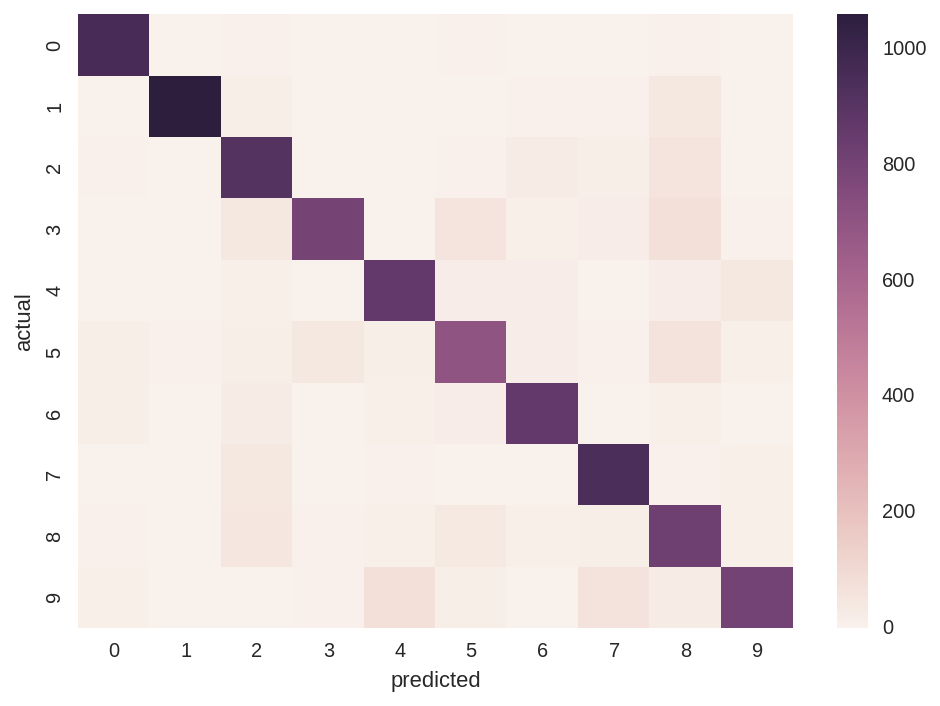

In [24]:
sns.heatmap(confusion_matrix(ytest, predict(Xtest)))
plt.xlabel('predicted')
plt.ylabel('actual');

# CNN